In [2]:
import pandas as pd
import numpy as np
import matplotlib
from watertap3.utils import watertap_setup, get_case_study, run_model 
from watertap3.utils import run_watertap3, run_model_no_print, run_and_return_model
import pyomo.util.infeasible as infeas
from idaes.core.util.model_statistics import *
import matplotlib.pyplot as plt
from truck_pipe_cost_functions import truck_costing, pipe_costing
from watertap3.utils.post_processing import get_results_table

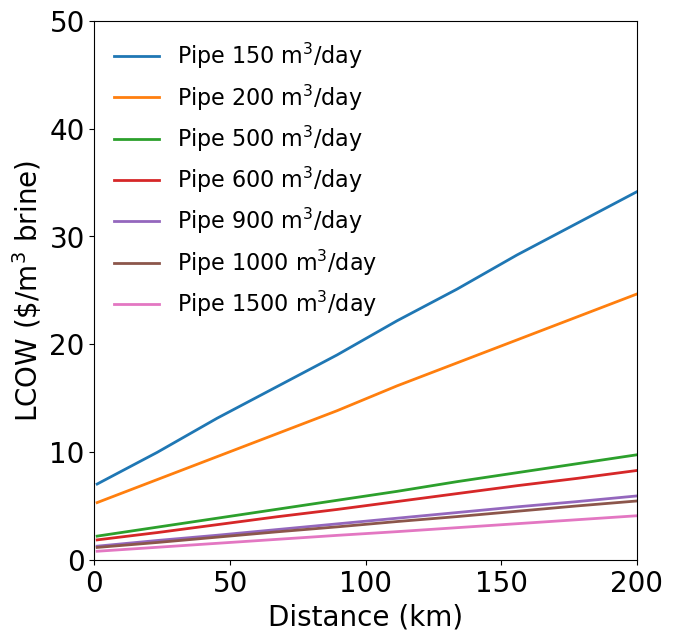

In [3]:
distance_input = np.linspace(1,200,10)
volume_input = [150,200,500,600,900,1000,1500]
output_pipe = []
output_truck_TX =[]
output_truck_CA =[]
output_truck_NM =[]

for d in distance_input:
    cost_truck_TX = truck_costing(d,wacc=0.1)
    cost_truck_CA = truck_costing(d,state='CA',wacc=0.1)
    cost_truck_NM = truck_costing(d,state='NM',wacc=0.1)
    output_truck_TX.append(cost_truck_TX)
    output_truck_CA.append(cost_truck_CA)
    output_truck_NM.append(cost_truck_NM)

for vol in volume_input:
    output_pipe_row = []
    for d in distance_input:
        cost_pipe = pipe_costing(vol,d,pump_power=20,pumping_velocity=2.7,hour_storage = 6)
        output_pipe_row.append(cost_pipe)
    output_pipe.append(output_pipe_row)

fig, ax = plt.subplots(figsize = (7,7))

for i in range(0,len(volume_input)):
    ax.plot(distance_input,output_pipe[i],label='Pipe '+ str(volume_input[i]) + r' ${\rm m^3}$/day',linewidth=2)
# ax.plot(distance_input,output_truck_TX,label = 'Truck (Texas)',linestyle= '--',linewidth=2)
# ax.plot(distance_input,output_truck_CA,label = 'Truck (California)',linestyle= '--',color='blue',linewidth=2)
# ax.plot(distance_input,output_truck_NM,label = 'Truck (New Mexico)',linestyle= '--',color='brown',linewidth=2)
ax.legend(fontsize = 16,frameon=False)

ax.set_xlabel("Distance (km)",fontsize = 20)
ax.set_ylabel(r'LCOW (\$/m${^3}$ brine)',fontsize = 20)
ax.set_xlim([0,200])
ax.set_ylim([0,50])

ax.tick_params(axis='both', which='major', labelsize=20)

Text(0, 0.5, 'LCOW ($/m3 brine)')

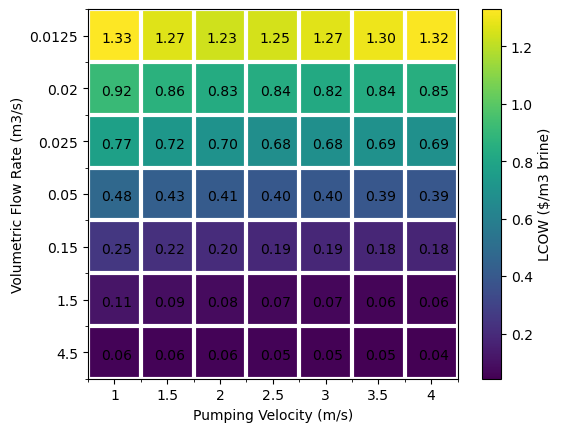

In [4]:
# Pumping velocity and capacity sensitivity
vol_list = [0.0125,0.02, 0.025, 0.05,0.15,1.5,4.5]
velocity_list = [1, 1.5,2,2.5,3,3.5,4]
lcow = np.zeros(shape=(len(vol_list),len(velocity_list)))
for i in range(0,len(vol_list)):
    for j in range(0,len(velocity_list)):
         lcow[i,j] = pipe_costing(vol_list[i]*3600*24,10,pumping_velocity=velocity_list[j],pump_power=24)

# lcow
fig,ax=plt.subplots()
im = ax.imshow(lcow)

ax.set_xticks(np.arange(lcow.shape[1] + 1) - 0.5, minor = True)
ax.set_yticks(np.arange(lcow.shape[0] + 1) - 0.5, minor = True)
ax.grid(which = "minor", color = "w", linestyle = '-', linewidth = 3)
ax.set_xticks(np.arange(len(velocity_list)), labels = velocity_list)
ax.set_yticks(np.arange(len(vol_list)), labels = vol_list)

valfmt="{x:.2f}"
# Get the formatter in case a string is supplied
if isinstance(valfmt, str):
    valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

textcolors = ("black", "white")
for i in range(0,len(vol_list)):
    for j in range(0,len(velocity_list)):
        im.axes.text(j-0.25, i+0.125, valfmt(lcow[i, j], None))
ax.set_ylabel('Volumetric Flow Rate (m3/s)')
ax.set_xlabel('Pumping Velocity (m/s)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('LCOW ($/m3 brine)')

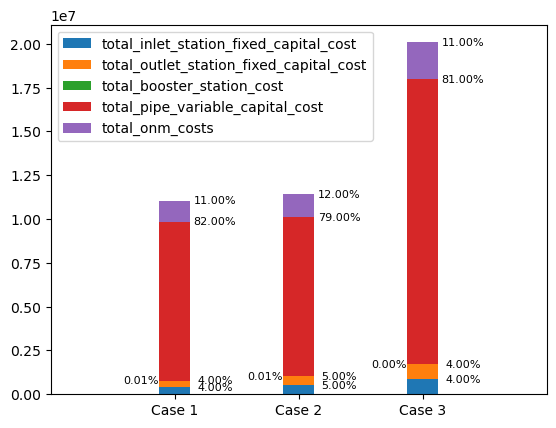

In [153]:
flow_rates = [2,2,4]
hours_storage = [4,6,6]

def get_transport_cost_breakdown(flow_rates,hours_storage):
    # Get the cost breakdown
    breakdown = []
    for i in range(0,len(flow_rates)):
        breakdown.append(pipe_costing(flow_rates[i]*3600*24,50,hour_storage=hours_storage[i],cost_break_down=True))
    cost_breakdown_df = pd.DataFrame(breakdown)

    return cost_breakdown_df

cost_breakdown_df = get_transport_cost_breakdown(flow_rates,hours_storage)
# print(cost_breakdown_df.transpose()[-7:-2])

def print_func(val):
    if val>0.1:
        return '{:.2f}%'.format(round(val))
    else:
        return '{:.2f}%'.format(val)
    

def plot_transport_cost_breakdown(cost_breakdown_df):
    # Make table of bottom and percentage for annotation
    # Percentage matrix
    cost_breakdown_df_transposed = cost_breakdown_df.transpose()[-7:-2]
    cost_breakdown_df_transposed_percent = cost_breakdown_df_transposed
    for i in range(0,len(cost_breakdown_df.transpose().columns)):
        cost_breakdown_df_transposed_percent[i] = cost_breakdown_df_transposed[i]/cost_breakdown_df_transposed[i].sum()*100
    
    # Bottoms
    bottoms = cost_breakdown_df.transpose()[-7:-2].cumsum()

    fig, ax = plt.subplots()
    cost_breakdown_df.transpose()[-7:-2].transpose().plot.bar(ax = ax,stacked=True,width = 0.25)
    for i in range(0,len(cost_breakdown_df.transpose()[-7:-2].index)):
        for j in range(0,len(cost_breakdown_df.index)):
            ax.text(ax.patches[j].get_x() + 0.45 - (cost_breakdown_df_transposed_percent.values[i,j] < 0.1)*0.6,
                    bottoms.values[i][j],
                    print_func(cost_breakdown_df_transposed_percent.values[i,j]), 
                    ha='center',
                    va='center',
                    fontdict={'fontsize' : 8})
    ax.set_xlim([-1,3])
    ax.set_xticklabels(['Case 1', 'Case 2', 'Case 3'],rotation = 0)
plot_transport_cost_breakdown(cost_breakdown_df)
    

In [ ]:
0.005*1000*(9)/2/0.25/1000/9.8*10000

91.83673469387755

In [ ]:
a = 40073.42661387725
b = 0.866701037568153
flow_in = 4.5*22.82
a*flow_in ** b

2219473.7752948166

In [ ]:
# Pumping velocity sensitivity
print(pipe_costing(4.5*10*3600*24,10,pumping_velocity=5,pump_power=20))
print(pipe_costing(0.0015*3600*24,10,pumping_velocity=1.5,pump_power=20))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=1.5,pump_power=20))

print(pipe_costing(0.0015*3600*24,10,pumping_velocity=3,pump_power=20))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=3,pump_power=20))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=3,pump_power=40))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=10,pump_power=20))


0.01146495409277592
8.63027740750741
0.05443473248960341
9.709572082145057
0.04653253589757084
0.04659251809843447
0.029606227961637758


In [ ]:
# Pump power

print(pipe_costing(4.5*3600*24,10,pumping_velocity=3,pump_power=20))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=3,pump_power=40))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=3,pump_power=500))

pump_power = 40 # kW
N = 1
electricity =  (N+1)*pump_power
electricity_rate = 0.06 #$/kwh
days_operation = 350
total_electricity_cost = electricity_rate * electricity *  days_operation * 24

total_electricity_cost

0.04653253589757084
0.04659251809843447
0.04791859053383311


40320.0

In [ ]:
# Pipe diameter
pipe_csa = 4.5/3
pipe_diameter = 2 * (pipe_csa/np.pi)**0.5
print(pipe_diameter*39.3701) # m to inches

print(pipe_costing(45*3600*24, 10, pumping_velocity=3, pump_power=20))

54.4085568564057
0.01146495409277592


In [ ]:
# Calculating the range of pump power to find the average pump power which is fixed in the transport function
def pump_power(flow_in, lift_height):
    flow_in_gpm = flow_in*1.585*1e4 #m3/s to gpm
    lift_height_ft = lift_height*3.28084  # m to ft
    return (0.746 * flow_in_gpm * lift_height_ft/ (3960 * 0.9 * 0.9)) 

print(pump_power(4.5,10))


544.2337295735128


In [ ]:
wacc = 0.05
plant_lifetime_yrs = 30
crf = (wacc * (1 + wacc) ** plant_lifetime_yrs) / (((1 + wacc) ** plant_lifetime_yrs) - 1)
plant_utilization = 350/365

In [ ]:
3/100*(10870+8855)/0.1

5917.5

In [ ]:
23532/crf*plant_utilization

346878.3045140067

In [ ]:
76960*(480/(560))**0.65

69622.50511792739

In [ ]:
0.1*2000000*(560*3/9400)**0.65

406.9934552055201

In [ ]:
tot_cost = 2000000*(480/9400)*0.65
per_year = tot_cost*0.1 #/(350/365)
per_year

6638.297872340427

In [ ]:
tot_cost = 1000000*(4.5*3600*24/9400)**0.65
per_year = tot_cost*0.065
per_year

730638.1052073875

In [ ]:
44**0.72093

2.7167089252275467

In [ ]:
a = 0.00344
b = 0.72093
flow = 4.5 #m3/s
storage_duration = 24 #h
storage_capacity = storage_duration*flow*3600 #convert to m3/h
storage_tank_capital_cost = a*storage_capacity**b

storage_tank_capital_cost

36843407.74974399

In [ ]:
4.5*3600*24

388800.0

In [ ]:
storage_capacity

388800.0

In [ ]:
0.1*13220*(0.206693**1.05)

252.53612508349474

In [ ]:
0.1*1322*(24**0.8)

1680.3527014398362

In [ ]:
pipe_costing(0.158987*40000,50)

0.6071552481475904

In [ ]:
# Checking costs from Zhou and Tol 2005
# Gruen 78 km pipeline, 75 million m3 per year, 300 m elevation. Estimate 25-34 cent/m3
print('LCOW',pipe_costing(75e6/365,78,elev_gain=300,hour_storage = 24))
# Uche 900 km, 1000 million m3 per year, 36 cent/m3
print('LCOW',pipe_costing(1000e6/365,900,elev_gain = 10,hour_storage = 24))
# Hahnemann 550 km, 1800 million m3 per year, 750 elevation. Estimate 74 cent/m3. This is an aquaduct
print('LCOW',pipe_costing(1800e6/365,550,elev_gain=750,hour_storage = 24))

print('LCOW',pipe_costing(100e6/365,280,elev_gain=320,hour_storage = 24))


pipe diameter (inch): 39.55378454686265
LCOW 0.27484003036936866
15.767214633203627
pipe diameter (inch): 63.0
LCOW 0.4690980174698058
28.380986339766533
pipe diameter (inch): 63.0
LCOW 0.172528698654626
pipe diameter (inch): 45.672776311199215
LCOW 0.8319838291817121


In [ ]:
pipe_costing(75e6/365,78,elev_gain=300)

0.2546717257428119

In [ ]:
pipe_costing(500,100*1.6)

8.9841550718874

In [ ]:
pipe_costing()

2220.0